Author: David Rodrigues | davidrodriguessp@hotmail.com | https://github.com/davidrodriguessp | https://www.linkedin.com/in/davidrodrigues/ <br>
*November 2021*

![bike image](https://images.unsplash.com/photo-1471506480208-91b3a4cc78be?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=874&q=80)

# Predicting Bike Rentals with Different Machine Learning Algorithms

The objective of this project is to build a model to predict the number of bikes rented in a specific hour, based on a series of features. We compared results from models using Linear Regression, Decision Tree and Random Forest.

The data analyzed contains 17,380 rows. Each row represents the number of bike rentals for a single hour in a specific day. The dataset can be downloaded on the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). The file we worked with is `hour.csv`.

[Here](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset) you can find a detailed description of the columns. `cnt` (count of total rental bikes) is the target variable we want to predict.

Comparing the results of multiple models, Random Forest was the algorithm which provided the best accuracy.

# Reading and Exploring the Data

In [1]:
# Read the dataset into a pandas dataframe
import pandas as pd
bike = pd.read_csv('hour.csv')

In [2]:
# Display the first five rows
bike.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


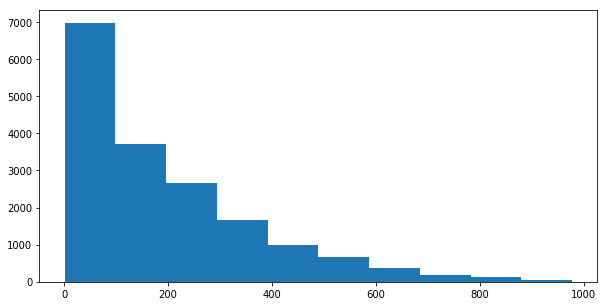

In [3]:
# Display a histogram of cnt with the number of bike rentals
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.hist(bike['cnt'])
plt.show()

As we can observe in the histogram, the data is right skewed. Most values show a considerably low number of rentals, less than 400 bikes per hour.

## Check for Correlation Among the Numeric Variables

In [4]:
# Show correlation between the features and cnt
numeric_columns = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
bike[numeric_columns].corr()

,temp,atemp,hum,windspeed,cnt
temp,1.000000,0.987672,-0.069881,-0.023125,0.404772
atemp,0.987672,1.000000,-0.051918,-0.062336,0.400929
hum,-0.069881,-0.051918,1.000000,-0.290105,-0.322911
windspeed,-0.023125,-0.062336,-0.290105,1.000000,0.093234
cnt,0.404772,0.400929,-0.322911,0.093234,1.000000


Looking at correlations, `temp` and `atemp` are highly correlated. We will drop `atemp` since its correlation with the target column `cnt` is lower.

When we look at how the columns are correlated with `cnt`, `temp` and `hum` show a stronger relation with the target column, while the correlation with `windspeed` is smaller.

# Accuracy Metric

The metric chosen was RMSE - Root Mean Squared error:
- It is adequate to regression problems, in which a numeric value is predicted
- The error metric is measured in the same unit as the target variable, what makes interpretation easier
- RMSE tends to penalize large errors, making the metric less prone to high variations

# Data Preparation
Below we create the function `transform`. With this function, we apply a series of operations to clean the dataset and convert the columns to a format fit for modeling.

The operations performed with the `transform` function:
- Drop columns that are irrelevant for the model we want to build
- Transform the variable `hr` converting it into 4 categories (early morning, morning, afternoon, night)
- Convert all categorical columns into dummy variables
- Drop columns that are highly correlated with other features

In [5]:
# Create a function transform to pre-process our dataset
def transform(df):
    
    # Create a copy of the datafram
    new = df.copy()
    
    # Remove unimportant columns
    new = new.drop(['instant', 'dteday', 'atemp', 'casual', 'registered'], axis=1)

    # Create a new column based on hr, returning 4 periods of the day: 6-12, 13-18, 19-23, 0-5
    def convert_hour(x):
        if 6 <= x <=12:
            return 1
        elif 13 <= x <=18:
            return 2
        elif 19 <= x <=23:
            return 3
        elif 0 <= x <=5:
            return 4
    
    new['time_label'] = new['hr'].apply(convert_hour)  
    
    # Remove hr column
    new = new.drop('hr', axis=1)

    # Convert categorical columns into dummies
    cat_cols = ['season', 'mnth', 'weekday', 'weathersit', 'time_label']
    for cat in cat_cols:
        dummy = pd.get_dummies(new[cat], prefix=cat, drop_first=True)
        new = pd.concat([new, dummy], axis=1)
        new.drop(cat, axis=1, inplace=True)
    
    return new

## Checking for Missing Values and Data Types

In [6]:
# Verify missing values and data types after transformation
transform(bike).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 33 columns):
yr              17379 non-null int64
holiday         17379 non-null int64
workingday      17379 non-null int64
temp            17379 non-null float64
hum             17379 non-null float64
windspeed       17379 non-null float64
cnt             17379 non-null int64
season_2        17379 non-null uint8
season_3        17379 non-null uint8
season_4        17379 non-null uint8
mnth_2          17379 non-null uint8
mnth_3          17379 non-null uint8
mnth_4          17379 non-null uint8
mnth_5          17379 non-null uint8
mnth_6          17379 non-null uint8
mnth_7          17379 non-null uint8
mnth_8          17379 non-null uint8
mnth_9          17379 non-null uint8
mnth_10         17379 non-null uint8
mnth_11         17379 non-null uint8
mnth_12         17379 non-null uint8
weekday_1       17379 non-null uint8
weekday_2       17379 non-null uint8
weekday_3       17379 non-null uin

As we can see above, after applying the function `transform`:
- There are no missing values
- All columns are numeric
- All categorical columns were converted into dummy variables.

# Spliting the Sample in Train and Test Sets
Next, we use our `transform` function to preprocess the `bike` dataset and split the data into train and test.

In [7]:
# Create the training set with 80% of the dataset and test with 20%
train = transform(bike).sample(frac=0.8, replace=False, random_state=42)
test = transform(bike)[transform(bike).index.isin(train.index) == False]

## Spliting the Data into Features and Target for Modeling

In [8]:
# Spliting the data into target and features
X_train = train.drop('cnt', axis=1)
X_test = test.drop('cnt', axis=1)
y_train = train['cnt']
y_test = test['cnt']

# Linear Regression Modeling
Now that the data is ready, let's run our first model.

In [9]:
# Fit a linear regression model on the training set
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, y_train)

# Create predictions on the test set
pred_lr = lr.predict(X_test)

#Calculate RMSE for the predictions on the test set
import numpy as np
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['cnt'], pred_lr))
print('Linear Regression RMSE: ', np.round(rmse))

Linear Regression RMSE:  125.0


The Linear Regression model is associated with a considerably high error. Let's see if using a Decision Tree improves results.

# Decision Tree Modeling

In [10]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth=12, min_samples_leaf=2, random_state=42).fit(X_train, y_train)
pred_dt = dt.predict(X_test)
rmse_dt = np.sqrt(mean_squared_error(test['cnt'], pred_dt))
print('Decision Tree RMSE: ', np.round(rmse_dt))

Decision Tree RMSE:  120.0


The Decision Tree has a slightly lower error if compared to the Linear Regression. Let's see if the Random Forest manages to improve results.

# Random Forest Modeling

In [11]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=50, max_depth=12, min_samples_leaf=2, max_features=15,
                           random_state=42).fit(X_train, y_train)
pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(test['cnt'], pred_rf))
print('Random Forest RMSE: ', np.round(rmse_rf))

Random Forest RMSE:  109.0


Finally, results are even better with the Random Forest. With this model, we managed to improve results substantially if compared to the one obtained with the Linear Regression.

Author: David Rodrigues | davidrodriguessp@hotmail.com | https://github.com/davidrodriguessp | https://www.linkedin.com/in/davidrodrigues/ <br> *November 2021*